# MLB data analysis 1: Using the career split data

In [179]:
import pandas as pd;
import numpy as np;

from matplotlib import pyplot as plt
plt.style.use('ggplot');
import scipy.stats as stats
import scipy as sp;

columns_career = ["ID", "Name", "Situation", "G", "AB", "R", "H", "2B", "3B", "HR", "RBI", "BB", "IBB", "SO", "HBP", "SH", \
                 "SF", "XI", "ROE", "GDP", "SB", "CS", "AVG", "OBP", "SLG"]; # len() = 25
columns_dtype = [str]*3 + [np.float64]*22;

columns_dtype_dict = dict(zip(columns_career, columns_dtype));

In [38]:
df_player_career_split = pd.read_csv("player_career_split_data.csv", usecols = columns_career, dtype = columns_dtype_dict);

## Testing if two binomial distributions are equal

We first formulate what we are trying to test. Suppose a batter's hitting average in non-RISP and RISP are $p_1$ and $p_2$, respectively, then our null hypothesis is

$$H_0: p_1 = p_2, \quad\text{ i.e. a batter is no stronger in clutch (RISP)}.$$

On the other hand, our alternative hypothesis is

$$H_A: p_1 < p_2, \quad\text{ i.e. a batter is stronger in clutch (RISP)}.$$

According to the literature (see, for instance, [here](https://stats.stackexchange.com/questions/113602/test-if-two-binomial-distributions-are-statistically-different-from-each-other) for a stackoverflow discussion), there are two major ways to determined if the two binomial distributions are identical.

1. Approximate the binomial distribution to a normal distribution. Suppose the sample size is $N$, and the probability is $p$, then as a rule of thumb, the binomial distribution is "close enough" to a normal distribution only if $Np, N(1-p)$ are both about 10 or larger. Since in baseball $p < 0.5$, we requested $N > 30$ for a better approximation.

    For a player, if the AB of non-RISP and RISP are $N_1$ and $N_2$, respectively, then the weighted average is $\displaystyle \hat p = \frac{N_1p_1 + N_2p_2}{N_1 + N_2}$, and the variance is $\displaystyle \sigma^2 = \hat p(1 - \hat p)\left(\frac{}{}\right)$. Under the assumption that $p_1 = p_2$, one can estimate the variance of the distributions and obtain the $z$-value as
    
    $$z = \frac{\hat p_2 - \hat p_1}{\sqrt{\hat p(1-\hat p)\left(N_1^{-1} + N_2^{-1}\right)}}.$$
    
    By passing the $z$-value to the error function, once can obtain the one-sided $p$-value. See the NIST document at the end for more information.
    
2. Using the Fisher's exact test. First, we have to set up a $2\times2$ contingency matrix, which is
    $$\begin{bmatrix}\#\{\text{non-hits in non-RISP}\} & \#\{\text{non-hits in RISP}\} \\ \#\{\text{hits in non-RISP}\} & \#\{\text{hits in RISP}\}\end{bmatrix}.$$
    
    Fisher's idea is based on a model on hypergeobetric series, but we skip the details. Using the built-in function from scipy, we can compute an one-sided $p$-value.

Comparing methods 1 and 2, Fisher's test had no assumptions which approximates a binomial distribution as a normal distribution, so it can be appropriate for smaller sample size, but it becomes slow for larger sample size.

In [243]:
AB_threshold = 30;

temp = df_player_career_split[df_player_career_split["Situation"] == "RISP"];
temp = temp[temp["AB"] >= AB_threshold];

RISP_comp = pd.merge(df_player_career_split[df_player_career_split["Situation"] == "Total"], temp, on = "ID");
# RISP_comp.loc[0] # Total: 3771, 12364, 964, 2956
#.merge(df_player_career_split[df_player_career_split["Situation"] == "RISP"], on = "ID")


print(RISP_comp.shape[0]-1)


6995


### 2. The Fisher exact method

In [180]:
p_RISP = [];
for i in range(RISP_comp.shape[0]):
    temp_list = RISP_comp.loc[i, ["AB_x", "H_x", "AB_y", "H_y"]];
    res = stats.fisher_exact([[temp_list[1]-temp_list[3], temp_list[3]], \
                              [temp_list[0]-temp_list[2]-(temp_list[1]-temp_list[3]), temp_list[2]-temp_list[3]]], \
                             alternative="greater")[1];
    p_RISP.append(res);

### Tracing $p$-values throughout the player database

The assumption we are actually interested is:

*For every batter, the null hypothesis $H_0: p_\text{RISP} = p_\text{non-RISP}$ holds true*.

In this case, if we use either method above, the $p$-values computed by each player should be an uniform distribution in $[0,1]$. We can test this hypothesis using the $\chi$-squared test.

KstestResult(statistic=0.08506902691461204, pvalue=1.7046376806880028e-44)

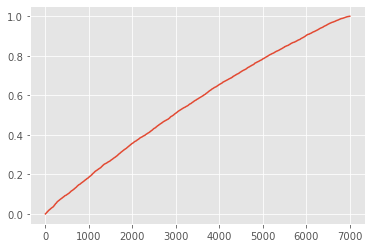

In [213]:
test = sorted(p_RISP)
plt.plot(test)

stats.kstest(test, stats.uniform(loc=0.0).cdf) # 1.70e-44
# This means that the null hypothesis should be rejected... But wait?

(array([227., 282., 281., 282., 274., 328., 282., 343., 307., 337., 345.,
        346., 333., 384., 382., 389., 421., 434., 437., 582.]),
 array([2.96194432e-05, 5.00276629e-02, 1.00025706e-01, 1.50023750e-01,
        2.00021793e-01, 2.50019837e-01, 3.00017880e-01, 3.50015924e-01,
        4.00013967e-01, 4.50012011e-01, 5.00010054e-01, 5.50008098e-01,
        6.00006141e-01, 6.50004184e-01, 7.00002228e-01, 7.50000271e-01,
        7.99998315e-01, 8.49996358e-01, 8.99994402e-01, 9.49992445e-01,
        9.99990489e-01]),
 <BarContainer object of 20 artists>)

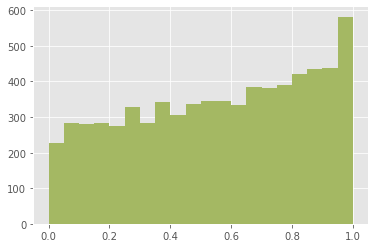

In [214]:
plt.hist(test, bins = 20, color = "#a4b863")

### It turns out that the hitting average at RISP is globally higher than at non-RISP. Can we adjust to that?

Unfortunately, things get a bit messy on that. I do not know of any rigorous mathematical model for that, but let's try...

In [222]:
# First idea: Try to multiply the AVG by a constant factor to balance the average in non-RISP and RISP.
# Equivalently, p_RISP = theta * p_nonRISP
test1 = [sum(RISP_comp[item]) for item in ["AB_x", "H_x", "AB_y", "H_y"]]; #12715568, 3348091, 3022597, 802629

test1 = [test1[1]/test1[0], test1[3]/test1[2], (test1[1]-test1[3])/(test1[0]-test1[2])]; #.2633, .2655, .2626
#theta = test1[1]/test1[2]; # 1.0111716751056685
theta = 1.0111716751056685;

### Now, let us try to implement the method "1. Approximation to normal distribution"

In [223]:
def Phi(x): # The cdf of the normal distribution N(0,1).
    return (1+sp.special.erf(x/2**0.5))/2;

def Binomial_p_val(x1, x2, N1, N2, theta=0): # In our application, N1: non-RISP, N2: RISP
    p1 = x1/N1;
    p2 = x2/N2;
    if theta != 0:
        p2 = p2/theta;
    
    phat = (p1*N1 + p2*N2)/(N1 + N2);
    return Phi((p2-p1)/np.sqrt(phat*(1-phat)*(1/N1+1/N2)));

In [224]:
p_RISP_2 = [];
p_RISP_3 = [];
for i in range(RISP_comp.shape[0]):
    temp_list = RISP_comp.loc[i, ["AB_x", "H_x", "AB_y", "H_y"]];
    res2 = Binomial_p_val(temp_list[1]-temp_list[3], temp_list[3], temp_list[0]-temp_list[2], temp_list[2], 0);
    res3 = Binomial_p_val(temp_list[1]-temp_list[3], temp_list[3], temp_list[0]-temp_list[2], temp_list[2], theta);
    p_RISP_2.append(res2);
    p_RISP_3.append(res3);

KstestResult(statistic=0.036174849581674495, pvalue=2.1700448058883414e-08)

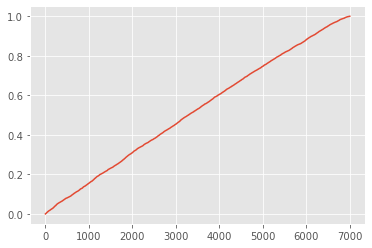

In [225]:
test = sorted(p_RISP_2)
plt.plot(test)

stats.kstest(test, stats.uniform(loc=0.0).cdf) #
# This means that the null hypothesis should be rejected... But wait?

(array([267., 371., 327., 298., 376., 293., 331., 360., 347., 322., 339.,
        332., 351., 341., 362., 356., 378., 372., 369., 504.]),
 array([4.28150841e-05, 5.00402498e-02, 1.00037684e-01, 1.50035119e-01,
        2.00032554e-01, 2.50029988e-01, 3.00027423e-01, 3.50024858e-01,
        4.00022293e-01, 4.50019727e-01, 5.00017162e-01, 5.50014597e-01,
        6.00012031e-01, 6.50009466e-01, 7.00006901e-01, 7.50004335e-01,
        8.00001770e-01, 8.49999205e-01, 8.99996639e-01, 9.49994074e-01,
        9.99991509e-01]),
 <BarContainer object of 20 artists>)

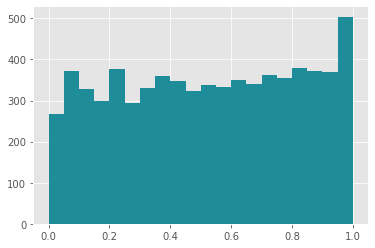

In [226]:
plt.hist(test, bins = 20, color = "#1f8c99")

KstestResult(statistic=0.013475397125518318, pvalue=0.1561262243686563)

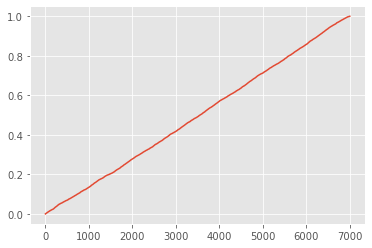

In [227]:
test = sorted(p_RISP_3)
plt.plot(test)

stats.kstest(test, stats.uniform(loc=0.0).cdf) #
# This means that the null hypothesis should be rejected... But wait?

(array([327., 407., 361., 368., 358., 346., 352., 336., 349., 348., 325.,
        346., 359., 308., 363., 341., 350., 322., 312., 418.]),
 array([3.41287437e-05, 5.00317866e-02, 1.00029444e-01, 1.50027102e-01,
        2.00024760e-01, 2.50022418e-01, 3.00020076e-01, 3.50017733e-01,
        4.00015391e-01, 4.50013049e-01, 5.00010707e-01, 5.50008365e-01,
        6.00006023e-01, 6.50003680e-01, 7.00001338e-01, 7.49998996e-01,
        7.99996654e-01, 8.49994312e-01, 8.99991969e-01, 9.49989627e-01,
        9.99987285e-01]),
 <BarContainer object of 20 artists>)

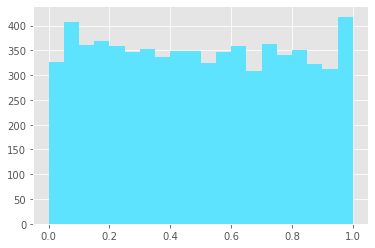

In [228]:
plt.hist(test, bins = 20, color = "#5ee3ff")

### Now this is the story of RISP, let us check out the other situations...

### Batting performance when there are men on base

In [242]:
AB_threshold = 30;

temp = df_player_career_split[df_player_career_split["Situation"] == "Men On"];
temp = temp[temp["AB"] >= AB_threshold];

MenOn_comp = pd.merge(df_player_career_split[df_player_career_split["Situation"] == "Total"], temp, on = "ID");
# RISP_comp.loc[0] # Total: 3771, 12364, 964, 2956
#.merge(df_player_career_split[df_player_career_split["Situation"] == "RISP"], on = "ID")


print(MenOn_comp.shape[0]-1) #7932


7932


In [230]:
# Finding the regression factor
test1 = [sum(MenOn_comp[item]) for item in ["AB_x", "H_x", "AB_y", "H_y"]]; #12832445, 3370884, 5326841, 1434549
test1 = [test1[1]/test1[0], test1[3]/test1[2], (test1[1]-test1[3])/(test1[0]-test1[2])]; #.2627, .2693, .2579
print(test1)
# theta = test1[1]/test1[2]; # 1.0111716751056685
theta = 1.0438805477041186

[0.2626844689379148, 0.26930576677621876, 0.25798523343357843]


In [252]:
p_MenOn_2 = [];
p_MenOn_3 = [];
for i in range(MenOn_comp.shape[0]):
    temp_list = MenOn_comp.loc[i, ["AB_x", "H_x", "AB_y", "H_y"]];
    res2 = Binomial_p_val(temp_list[1]-temp_list[3], temp_list[3], temp_list[0]-temp_list[2], temp_list[2], 0);
    res3 = Binomial_p_val(temp_list[1]-temp_list[3], temp_list[3], temp_list[0]-temp_list[2], temp_list[2], theta);
    p_MenOn_2.append(res2);
    p_MenOn_3.append(res3);

KstestResult(statistic=0.11881777585785502, pvalue=4.8275052325738524e-98)

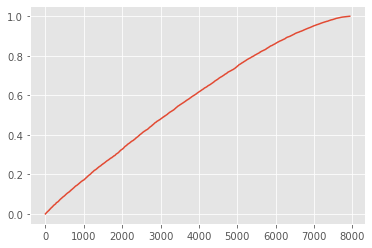

In [253]:
test = sorted(p_MenOn_2)
plt.plot(test)

stats.kstest(test, stats.uniform(loc=0.0).cdf) #
# This means that the null hypothesis should be rejected... But wait?

(array([262., 280., 312., 310., 317., 351., 299., 327., 334., 360., 340.,
        382., 380., 383., 383., 417., 436., 514., 590., 956.]),
 array([1.00237577e-04, 5.00952257e-02, 1.00090214e-01, 1.50085202e-01,
        2.00080190e-01, 2.50075178e-01, 3.00070166e-01, 3.50065154e-01,
        4.00060143e-01, 4.50055131e-01, 5.00050119e-01, 5.50045107e-01,
        6.00040095e-01, 6.50035083e-01, 7.00030071e-01, 7.50025059e-01,
        8.00020047e-01, 8.50015036e-01, 9.00010024e-01, 9.50005012e-01,
        1.00000000e+00]),
 <BarContainer object of 20 artists>)

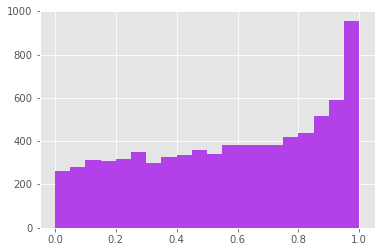

In [237]:
plt.hist(test, bins = 20, color = "#b241e9")

KstestResult(statistic=0.040749230467747366, pvalue=6.976218886226335e-12)

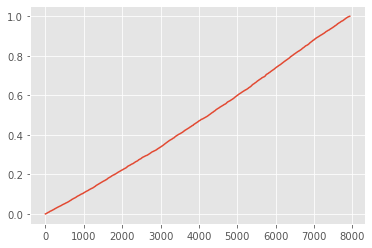

In [238]:
test = sorted(p_MenOn_3)
plt.plot(test)

stats.kstest(test, stats.uniform(loc=0.0).cdf) #
# This means that the null hypothesis should be rejected... But wait?

(array([483., 448., 448., 427., 427., 444., 408., 366., 403., 409., 367.,
        378., 369., 357., 347., 345., 353., 364., 397., 393.]),
 array([5.09751581e-05, 5.00484219e-02, 1.00045869e-01, 1.50043315e-01,
        2.00040762e-01, 2.50038209e-01, 3.00035655e-01, 3.50033102e-01,
        4.00030549e-01, 4.50027996e-01, 5.00025442e-01, 5.50022889e-01,
        6.00020336e-01, 6.50017782e-01, 7.00015229e-01, 7.50012676e-01,
        8.00010123e-01, 8.50007569e-01, 9.00005016e-01, 9.50002463e-01,
        9.99999909e-01]),
 <BarContainer object of 20 artists>)

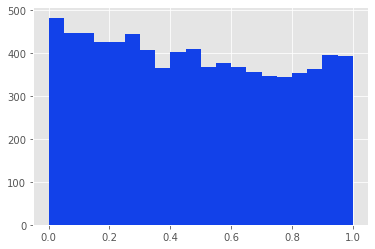

In [240]:
plt.hist(test, bins = 20, color = "#1241e9")

It turned out that using the batting data from the situation when there is runner on the base, there is a statitical significance between the normalized p-value and the uniform distribution on $(0,1)$.

### Batting performance in close and late situations

In [244]:
AB_threshold = 30;

temp = df_player_career_split[df_player_career_split["Situation"] == "Close & Late"];
temp = temp[temp["AB"] >= AB_threshold];

CnL_comp = pd.merge(df_player_career_split[df_player_career_split["Situation"] == "Total"], temp, on = "ID");

print(CnL_comp.shape[0]-1) #5909


5909


In [248]:
# Finding the regression factor
test1 = [sum(CnL_comp[item]) for item in ["AB_x", "H_x", "AB_y", "H_y"]]; #12456418, 3304112, 1959958, 503491
print(test1)
test1 = [test1[1]/test1[0], test1[3]/test1[2], (test1[1]-test1[3])/(test1[0]-test1[2])]; #.2653, .2569, .2668
print(test1)
# theta = test1[1]/test1[2]; # 0.9627941904139188
theta = 0.9627941904139188;

[12456418.0, 3304112.0, 1959958.0, 503491.0]
[0.26525378323046, 0.256888668022478, 0.26681576455300166]


0.9627941904139188

In [251]:
p_CnL_2 = [];
p_CnL_3 = [];
for i in range(CnL_comp.shape[0]):
    temp_list = CnL_comp.loc[i, ["AB_x", "H_x", "AB_y", "H_y"]];
    res2 = Binomial_p_val(temp_list[1]-temp_list[3], temp_list[3], temp_list[0]-temp_list[2], temp_list[2], 0);
    res3 = Binomial_p_val(temp_list[1]-temp_list[3], temp_list[3], temp_list[0]-temp_list[2], temp_list[2], theta);
    p_CnL_2.append(res2);
    p_CnL_3.append(res3);

KstestResult(statistic=0.13703345362728642, pvalue=2.906318485046126e-97)

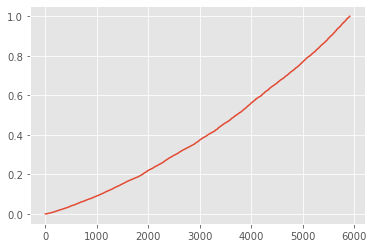

In [256]:
test = sorted(p_CnL_2)
plt.plot(test)

stats.kstest(test, stats.uniform(loc=0.0).cdf)


(array([600., 479., 405., 401., 322., 312., 350., 284., 284., 268., 245.,
        247., 234., 255., 233., 215., 208., 201., 184., 183.]),
 array([3.93062695e-06, 5.00017451e-02, 9.99995596e-02, 1.49997374e-01,
        1.99995188e-01, 2.49993003e-01, 2.99990817e-01, 3.49988632e-01,
        3.99986446e-01, 4.49984261e-01, 4.99982075e-01, 5.49979890e-01,
        5.99977704e-01, 6.49975519e-01, 6.99973333e-01, 7.49971148e-01,
        7.99968962e-01, 8.49966777e-01, 8.99964591e-01, 9.49962405e-01,
        9.99960220e-01]),
 <BarContainer object of 20 artists>)

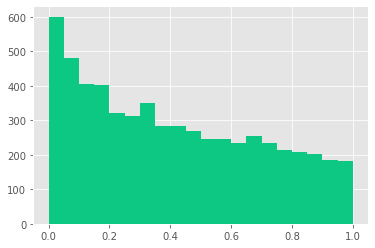

In [257]:
plt.hist(test, bins = 20, color = "#0dc883")

KstestResult(statistic=0.025072277809333576, pvalue=0.0011654972497789032)

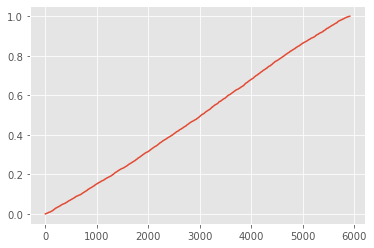

In [258]:
test = sorted(p_CnL_3)
plt.plot(test)

stats.kstest(test, stats.uniform(loc=0.0).cdf)

(array([345., 351., 288., 334., 296., 283., 286., 286., 279., 280., 259.,
        262., 301., 241., 278., 265., 288., 322., 302., 364.]),
 array([4.26555520e-05, 5.00402647e-02, 1.00037874e-01, 1.50035483e-01,
        2.00033092e-01, 2.50030701e-01, 3.00028310e-01, 3.50025919e-01,
        4.00023528e-01, 4.50021138e-01, 5.00018747e-01, 5.50016356e-01,
        6.00013965e-01, 6.50011574e-01, 7.00009183e-01, 7.50006792e-01,
        8.00004401e-01, 8.50002011e-01, 8.99999620e-01, 9.49997229e-01,
        9.99994838e-01]),
 <BarContainer object of 20 artists>)

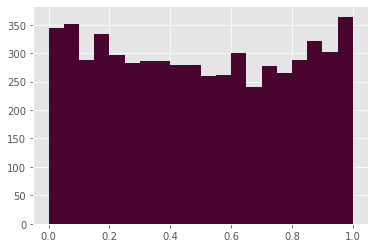

In [259]:
plt.hist(test, bins = 20, color = "#49042f")

Although it seems more uniform than the case when there are men on base, statistics still refutes the null hypothesis that the normalized $p$-values is indistinguishable to a uniform distribution.

### Batting performance when bases are loaded

In [260]:
AB_threshold = 30;

temp = df_player_career_split[df_player_career_split["Situation"] == "Bases Loaded"];
temp = temp[temp["AB"] >= AB_threshold];

BasesLoaded_comp = pd.merge(df_player_career_split[df_player_career_split["Situation"] == "Total"], temp, on = "ID");

print(BasesLoaded_comp.shape[0]-1) #2780


2780


In [264]:
# Finding the regression factor
test1 = [sum(BasesLoaded_comp[item]) for item in ["AB_x", "H_x", "AB_y", "H_y"]]; #10351603, 2803442, 232191, 66304
print(test1)
test1 = [test1[1]/test1[0], test1[3]/test1[2], (test1[1]-test1[3])/(test1[0]-test1[2])]; #.2708, .2856, .2705
print(test1)
theta = test1[1]/test1[2] # 1.0557301668575974
theta = 1.0557301668575974;

[10351603.0, 2803442.0, 232191.0, 66304.0]
[0.27082201664804956, 0.28555801043106754, 0.2704838976810115]


In [270]:
p_BasesLoaded_2 = [];
p_BasesLoaded_3 = [];
for i in range(BasesLoaded_comp.shape[0]):
    temp_list = BasesLoaded_comp.loc[i, ["AB_x", "H_x", "AB_y", "H_y"]];
    res2 = Binomial_p_val(temp_list[1]-temp_list[3], temp_list[3], temp_list[0]-temp_list[2], temp_list[2], 0);
    res3 = Binomial_p_val(temp_list[1]-temp_list[3], temp_list[3], temp_list[0]-temp_list[2], temp_list[2], theta);
    p_BasesLoaded_2.append(res2);
    p_BasesLoaded_3.append(res3);

KstestResult(statistic=0.11651086442825875, pvalue=2.396877258226524e-33)

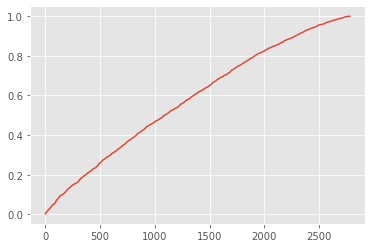

In [271]:
test = sorted(p_BasesLoaded_2)
plt.plot(test)

stats.kstest(test, stats.uniform(loc=0.0).cdf)


(array([ 80.,  80., 101., 111., 113., 114., 118., 115., 119., 143., 136.,
        125., 145., 132., 136., 146., 179., 190., 195., 303.]),
 array([0.00189399, 0.05179898, 0.10170397, 0.15160896, 0.20151395,
        0.25141894, 0.30132393, 0.35122892, 0.40113391, 0.4510389 ,
        0.50094389, 0.55084888, 0.60075387, 0.65065885, 0.70056384,
        0.75046883, 0.80037382, 0.85027881, 0.9001838 , 0.95008879,
        0.99999378]),
 <BarContainer object of 20 artists>)

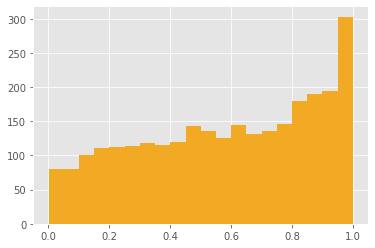

In [272]:
plt.hist(test, bins = 20, color = "#f2a923")

KstestResult(statistic=0.015143613606978024, pvalue=0.5413150248203669)

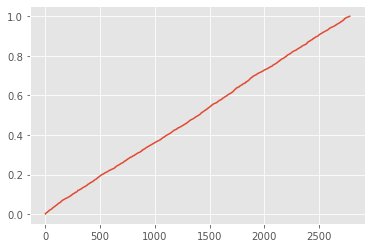

In [273]:
test = sorted(p_BasesLoaded_3)
plt.plot(test)

stats.kstest(test, stats.uniform(loc=0.0).cdf)


(array([114., 136., 139., 132., 155., 145., 147., 146., 149., 138., 120.,
        139., 125., 124., 166., 129., 143., 141., 149., 144.]),
 array([8.26689640e-04, 5.07822814e-02, 1.00737873e-01, 1.50693465e-01,
        2.00649057e-01, 2.50604649e-01, 3.00560240e-01, 3.50515832e-01,
        4.00471424e-01, 4.50427016e-01, 5.00382608e-01, 5.50338200e-01,
        6.00293791e-01, 6.50249383e-01, 7.00204975e-01, 7.50160567e-01,
        8.00116159e-01, 8.50071750e-01, 9.00027342e-01, 9.49982934e-01,
        9.99938526e-01]),
 <BarContainer object of 20 artists>)

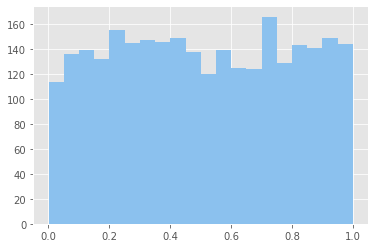

In [274]:
plt.hist(test, bins = 20, color = "#8bc1ee")

This one is flat.

### Storing the data, and move on

## Some statistical references

- How can we determine whether two processes produce the same proportion of defectives? From NIST
    https://www.itl.nist.gov/div898/handbook/prc/section3/prc33.htm
- Fischer's exact test (have implementation in scipy)
    https://en.wikipedia.org/wiki/Fisher's_exact_test
- Barnard's test (have documentation in scipy, but the function seemed to be removed)
    https://en.wikipedia.org/wiki/Barnard%27s_test
